# PRÁCTICA GUIADA 02

---
**Curso:** Data Mining Tools  
**Semestre:** 2025-2  
**Docente:** Carlos Fernando Montoya Cubas  
**Grupo:** 08  

---


## ALUMNOS
- Mildred Micaela Marchan Quispe  
- Rody Sebastian Vilchez Marin  
- Rosa Maria Rodríguez Valencia

## Instrucciones:  

Dado el dataset de fraude crediticio disponible en:   
https://www.kaggle.com/datasets/mishra5001/credit-card/data  
1. Realizar el preprocesamiento de variables y examinar las relaciones entre los 
datos.  
 
2. Realizar el escalamiento multidimensional de los datos y realizar la 
interpretación correspondiente.  
 
3. Crear una clase en python que reciba como parámetro el dataset y los  
transformadores correspondientes y pueda realizar el preprocesamiento de las 
variables. La clase debe interpretar la función fit que calibra los  
transformadores y la función transform que realiza la transformación  
propiamente dicha. 


In [1]:
!pip install pandas matplotlib seaborn scikit-learn wordcloud -q

In [2]:

# paquete que implementa varios métodos de codificación de variables categóricas
!pip install category_encoders kaggle -q


In [3]:
!pip install umap-learn pynndescent numba -q

In [4]:

## Cargando las bibliotecas
# importa  pandas
import pandas as pd

# gráficos
import matplotlib.pyplot as plt
import seaborn as sns

# Escalonamento multidmensional
from sklearn.manifold import MDS

# transformacion de atributos
from category_encoders import OneHotEncoder, OrdinalEncoder

# cálculo de distancias
from scipy.spatial.distance import pdist, squareform



## Base de datos

**Credit Card Fraud Detection**

Este dataset busca obtener insights sobre clientes que incumplen pagos de tarjetas de crédito, usando atributos como Income_Total, AMT_APPLICATION, AMT_CREDIT y más de 120 variables.

Incluye también el Previous Application Data Set, que permite analizar patrones y variaciones considerando el historial crediticio.

Fue tomado como parte de una asignación académica, aplicando EDA para identificar tendencias y riesgos de incumplimiento. [aqui](https://www.kaggle.com/datasets/mishra5001/credit-card/data)


In [5]:

!kaggle datasets download -d mishra5001/credit-card # setear kaggle api

!mkdir -p data
!unzip -o credit-card.zip -d data # comprimir en data
!rm credit-card.zip # borrar zip


Dataset URL: https://www.kaggle.com/datasets/mishra5001/credit-card
License(s): other
  0%|                                                | 0.00/112M [00:00<?, ?B/s]
100%|████████████████████████████████████████| 112M/112M [00:00<00:00, 3.19GB/s]
Archive:  credit-card.zip
  inflating: data/application_data.csv  
  inflating: data/columns_description.csv  
  inflating: data/previous_application.csv  


In [6]:

APP = pd.read_csv('data/application_data.csv')
print(APP.shape)
APP.head(2)

(307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:

PREVIOUS = pd.read_csv('data/previous_application.csv')
print(PREVIOUS.shape)
PREVIOUS.head(2)


(1670214, 37)


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0


In [8]:
COLUMNS = pd.read_csv('data/columns_description.csv',sep=",", encoding='cp1252', index_col=0)
print(COLUMNS.shape)
COLUMNS.head(2)

(160, 4)


,Table,Row,Description,Special
1,application_data,SK_ID_CURR,ID of loan in our sample,NaN
2,application_data,TARGET,Target variable (1 - client with payment diffi...,NaN



### Seleccion del dataset

Los datos de la aplicación principal se encuentran en el archivo `application_data.csv`, que contiene 122 columnas y 307511 filas. El conjunto de datos de aplicaciones previas está en `previous_application.csv`, con 37 columnas y 1670214 filas. La descripción de las columnas está en `columns_description.csv`.

Exploraremos `columns_description.csv` para entender las variables, y luego escogeremos un conjunto de datos para análisis y preprocesamiento.


In [9]:


COLUMNS["Table"].value_counts()

Table
application_data            122
previous_application.csv     38
Name: count, dtype: int64

In [10]:

COLUMNS[COLUMNS['Table'] == 'application_data'].describe().T

,count,unique,top,freq
Table,122,1,application_data,122
Row,122,122,SK_ID_CURR,1
Description,122,73,Normalized information about building where th...,47
Special,56,4,normalized,50


In [11]:

COLUMNS[COLUMNS['Table'] == 'previous_application.csv'].describe().T


,count,unique,top,freq
Table,38,1,previous_application.csv,38
Row,38,38,SK_ID_PREV,1
Description,38,37,Interest rate normalized on previous credit,2
Special,13,5,time only relative to the application,6




Tratamiento`Special` segun tipo de tabla`Table`


In [12]:

dfs = COLUMNS['Table'].unique()

for df in dfs:
    prev_app = COLUMNS[COLUMNS['Table'] == df]
    freq = prev_app['Special'].value_counts(normalize=True, dropna=False) * 100
    freq = freq.round(2)
    print(df, end="\n\n")
    
    print(freq)
    print("\n\n")


application_data

Special
NaN                                      54.10
normalized                               40.98
time only relative to the application     3.28
normalized                                0.82
rounded                                   0.82
Name: proportion, dtype: float64



previous_application.csv

Special
NaN                                      65.79
time only relative to the application    15.79
normalized                                7.89
hashed                                    5.26
rounded                                   2.63
grouped                                   2.63
Name: proportion, dtype: float64





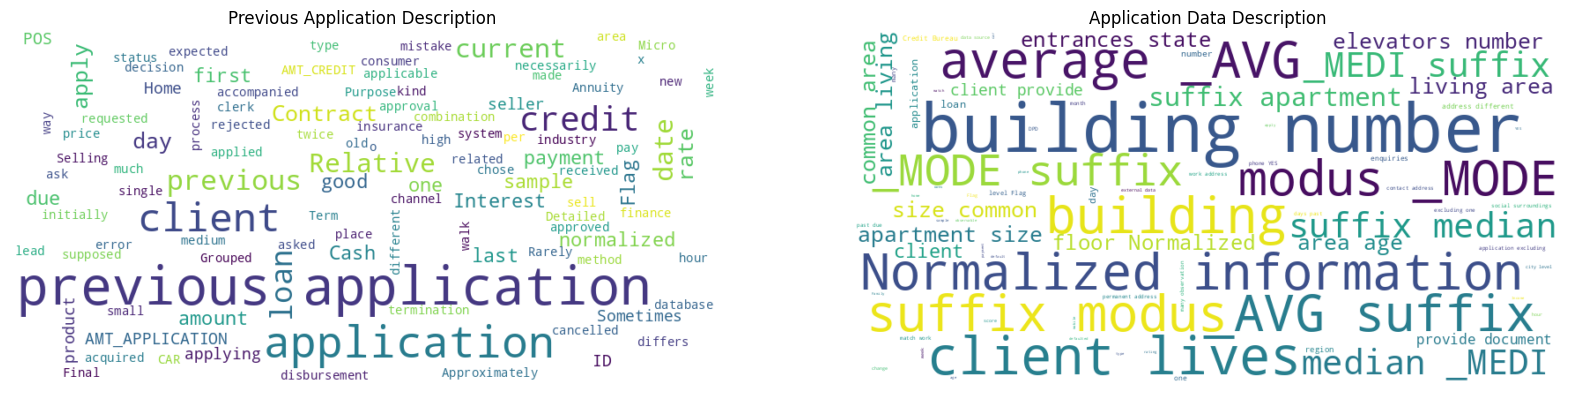

In [13]:

# wordclod por tratamiento `Special` por tipo de tabla`Table`
from wordcloud import WordCloud

text_prev = ' '.join(COLUMNS[COLUMNS['Table'] == 'previous_application.csv']['Description'].dropna().values)
text_app = ' '.join(COLUMNS[COLUMNS['Table'] == 'application_data']['Description'].dropna().values)


wordcloud_prev = WordCloud(width=800, height=400, background_color='white').generate(text_prev)
wordcloud_app = WordCloud(width=800, height=400, background_color='white').generate(text_app)

plt.figure(figsize=(20, 16))

plt.subplot(121)
plt.imshow(wordcloud_prev, interpolation='bilinear')
plt.title('Previous Application Description')
plt.axis('off')

plt.subplot(122)
plt.imshow(wordcloud_app, interpolation='bilinear')
plt.title('Application Data Description')
plt.axis('off')
plt.show()



Dado que el proposito de la leccion es limpiar datos, se opta por trabajar con el dataset `previoys_application.csv` que contiene los datos crudos. Este conjunto es el mas adecuado para aplicar y practicar tecnicas de preprocesamiento y analisis exploratorio.

El dataset de `application_data.csv` se podra llegar a usar como control


In [14]:

# descripcion de los atributos numéricos
PREVIOUS.describe().T

,count,mean,std,min,25%,50%,75%,max
SK_ID_PREV,1670214.0,1.923089e+06,532597.958696,1.000001e+06,1.461857e+06,1.923110e+06,2.384280e+06,2845382.000
SK_ID_CURR,1670214.0,2.783572e+05,102814.823849,1.000010e+05,1.893290e+05,2.787145e+05,3.675140e+05,456255.000
AMT_ANNUITY,1297979.0,1.595512e+04,14782.137335,0.000000e+00,6.321780e+03,1.125000e+04,2.065842e+04,418058.145
AMT_APPLICATION,1670214.0,1.752339e+05,292779.762386,0.000000e+00,1.872000e+04,7.104600e+04,1.803600e+05,6905160.000
AMT_CREDIT,1670213.0,1.961140e+05,318574.616547,0.000000e+00,2.416050e+04,8.054100e+04,2.164185e+05,6905160.000
AMT_DOWN_PAYMENT,774370.0,6.697402e+03,20921.495410,-9.000000e-01,0.000000e+00,1.638000e+03,7.740000e+03,3060045.000
AMT_GOODS_PRICE,1284699.0,2.278473e+05,315396.557937,0.000000e+00,5.084100e+04,1.123200e+05,2.340000e+05,6905160.000
HOUR_APPR_PROCESS_START,1670214.0,1.248418e+01,3.334028,0.000000e+00,1.000000e+01,1.200000e+01,1.500000e+01,23.000
NFLAG_LAST_APPL_IN_DAY,1670214.0,9.964675e-01,0.059330,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000
RATE_DOWN_PAYMENT,774370.0,7.963682e-02,0.107823,-1.497876e-05,0.000000e+00,5.160508e-02,1.089091e-01,1.000


In [15]:

# descripcion de los atributos categóricos
PREVIOUS.describe(include = 'object').T

,count,unique,top,freq
NAME_CONTRACT_TYPE,1670214,4,Cash loans,747553
WEEKDAY_APPR_PROCESS_START,1670214,7,TUESDAY,255118
FLAG_LAST_APPL_PER_CONTRACT,1670214,2,Y,1661739
NAME_CASH_LOAN_PURPOSE,1670214,25,XAP,922661
NAME_CONTRACT_STATUS,1670214,4,Approved,1036781
NAME_PAYMENT_TYPE,1670214,4,Cash through the bank,1033552
CODE_REJECT_REASON,1670214,9,XAP,1353093
NAME_TYPE_SUITE,849809,7,Unaccompanied,508970
NAME_CLIENT_TYPE,1670214,4,Repeater,1231261
NAME_GOODS_CATEGORY,1670214,28,XNA,950809


In [16]:
PREVIOUS.isnull().mean().sort_values(ascending=False).__round__(3).head(5)

RATE_INTEREST_PRIVILEGED    0.996
RATE_INTEREST_PRIMARY       0.996
AMT_DOWN_PAYMENT            0.536
RATE_DOWN_PAYMENT           0.536
NAME_TYPE_SUITE             0.491
dtype: float64

In [17]:
#sns.heatmap(PREVIOUS.isnull(), cbar=False) # demora 2 dias

Vamos a analizar los atributos categóricos, para clasificarlos entre discreto y ordinal


In [18]:

for column_name in PREVIOUS.select_dtypes(include=["object_"]):
  print(column_name, "->", PREVIOUS[column_name].unique())
  print()
  


NAME_CONTRACT_TYPE -> ['Consumer loans' 'Cash loans' 'Revolving loans' 'XNA']

WEEKDAY_APPR_PROCESS_START -> ['SATURDAY' 'THURSDAY' 'TUESDAY' 'MONDAY' 'FRIDAY' 'SUNDAY' 'WEDNESDAY']

FLAG_LAST_APPL_PER_CONTRACT -> ['Y' 'N']

NAME_CASH_LOAN_PURPOSE -> ['XAP' 'XNA' 'Repairs' 'Everyday expenses' 'Car repairs'
 'Building a house or an annex' 'Other' 'Journey'
 'Purchase of electronic equipment' 'Medicine' 'Payments on other loans'
 'Urgent needs' 'Buying a used car' 'Buying a new car'
 'Buying a holiday home / land' 'Education' 'Buying a home' 'Furniture'
 'Buying a garage' 'Business development' 'Wedding / gift / holiday'
 'Hobby' 'Gasification / water supply' 'Refusal to name the goal'
 'Money for a third person']

NAME_CONTRACT_STATUS -> ['Approved' 'Refused' 'Canceled' 'Unused offer']

NAME_PAYMENT_TYPE -> ['Cash through the bank' 'XNA' 'Non-cash from your account'
 'Cashless from the account of the employer']

CODE_REJECT_REASON -> ['XAP' 'HC' 'LIMIT' 'CLIENT' 'SCOFR' 'SCO' 'XNA' 'VER

Vamos a separar los atributos nominales y ordinales para hacer una transformacion a numérica, para calcular distancias:
    


In [19]:
nominal_cols = ['NAME_CONTRACT_TYPE', 'NAME_CASH_LOAN_PURPOSE', 
                'NAME_PAYMENT_TYPE', 'CODE_REJECT_REASON', 'NAME_TYPE_SUITE', 
                'NAME_CLIENT_TYPE', 'NAME_GOODS_CATEGORY', 'NAME_PORTFOLIO',
                'NAME_PRODUCT_TYPE', 'CHANNEL_TYPE','NAME_SELLER_INDUSTRY',
                'PRODUCT_COMBINATION', 'FLAG_LAST_APPL_PER_CONTRACT',  'NAME_CONTRACT_STATUS'
                ]

ordinal_cols = ['WEEKDAY_APPR_PROCESS_START', 
               'NAME_YIELD_GROUP'
                ]

In [20]:
mappings = [
    {'col': 'WEEKDAY_APPR_PROCESS_START',
     'mapping': {
         'MONDAY': 0,
         'TUESDAY': 1,
         'WEDNESDAY': 2,
         'THURSDAY': 3,
         'FRIDAY': 4,
         'SATURDAY': 5,
         'SUNDAY': 6
     }},
    
    {'col': 'NAME_YIELD_GROUP',
     'mapping': {
         'low_action': 0,
         'low_normal': 1,
         'middle': 2,
         'high': 3,
         'XNA': -1
     }}
]



Precisamos explicitar a ordem para os atributos ordinais, uma vez que a ordem em que eles aparacem pode ser diferente da ordem desejada:
    


Ahora vamos a crear los objetos que hacen la transformación. Para los atributos nominales, utilizaremos la codificación 1 de m (One-Hot-Encoding). En cuanto a los atributos categóricos, usemos el orden creado anteriormente

In [21]:
onehotenc = OneHotEncoder(cols = nominal_cols)
ordinalenc = OrdinalEncoder(cols = ordinal_cols, mapping = mappings)

Inicialmente, transformamos os atributos nominales:

In [22]:
PREVIOUS_1 = onehotenc.fit_transform(PREVIOUS)

In [23]:
PREVIOUS_1.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE_1,NAME_CONTRACT_TYPE_2,NAME_CONTRACT_TYPE_3,NAME_CONTRACT_TYPE_4,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,...,PRODUCT_COMBINATION_15,PRODUCT_COMBINATION_16,PRODUCT_COMBINATION_17,PRODUCT_COMBINATION_18,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,1,0,0,0,1730.430,17145.0,17145.0,0.0,...,0,0,0,0,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,0,1,0,0,25188.615,607500.0,679671.0,NaN,...,0,0,0,0,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,0,1,0,0,15060.735,112500.0,136444.5,NaN,...,0,0,0,0,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,0,1,0,0,47041.335,450000.0,470790.0,NaN,...,0,0,0,0,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,0,1,0,0,31924.395,337500.0,404055.0,NaN,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


Ahora aplicamos la transformacion de los ordinales:

In [24]:
PREVIOUS_2 = ordinalenc.fit_transform(PREVIOUS_1)

In [25]:
PREVIOUS_2

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE_1,NAME_CONTRACT_TYPE_2,NAME_CONTRACT_TYPE_3,NAME_CONTRACT_TYPE_4,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,...,PRODUCT_COMBINATION_15,PRODUCT_COMBINATION_16,PRODUCT_COMBINATION_17,PRODUCT_COMBINATION_18,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,1,0,0,0,1730.430,17145.0,17145.0,0.0,...,0,0,0,0,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,0,1,0,0,25188.615,607500.0,679671.0,NaN,...,0,0,0,0,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,0,1,0,0,15060.735,112500.0,136444.5,NaN,...,0,0,0,0,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,0,1,0,0,47041.335,450000.0,470790.0,NaN,...,0,0,0,0,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,0,1,0,0,31924.395,337500.0,404055.0,NaN,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1670209,2300464,352015,1,0,0,0,14704.290,267295.5,311400.0,0.0,...,0,0,0,0,365243.0,-508.0,362.0,-358.0,-351.0,0.0
1670210,2357031,334635,1,0,0,0,6622.020,87750.0,64291.5,29250.0,...,0,0,0,0,365243.0,-1604.0,-1274.0,-1304.0,-1297.0,0.0
1670211,2659632,249544,1,0,0,0,11520.855,105237.0,102523.5,10525.5,...,0,0,0,0,365243.0,-1457.0,-1187.0,-1187.0,-1181.0,0.0
1670212,2785582,400317,0,1,0,0,18821.520,180000.0,191880.0,NaN,...,0,0,0,0,365243.0,-1155.0,-825.0,-825.0,-817.0,1.0


Finalmente, un tratamento de valores ausentes

In [26]:
PREVIOUS_3 = PREVIOUS_2.fillna(PREVIOUS_2.median())

In [27]:
PREVIOUS_3.isnull().sum().sum()

0

Para acelerar los cálculos, tomemos una muestra aleatoria de esta versión procesada. Además, para que un atributo no tenga mayor importancia que los demás, cambiemos la escala para que todos tengan valores entre 0 y 1:

In [28]:

sample = PREVIOUS_3.sample(1000)
print(sample.columns.to_list())

max_amt_credit = max(sample.AMT_CREDIT)
max_rate_down_payment = max(sample.RATE_DOWN_PAYMENT)

# normalización Min-Max
sample = sample.loc[:, sample.nunique() > 1]
sample = (sample - sample.min()) / (sample.max() - sample.min()) # evita columnas constantes


['SK_ID_PREV', 'SK_ID_CURR', 'NAME_CONTRACT_TYPE_1', 'NAME_CONTRACT_TYPE_2', 'NAME_CONTRACT_TYPE_3', 'NAME_CONTRACT_TYPE_4', 'AMT_ANNUITY', 'AMT_APPLICATION', 'AMT_CREDIT', 'AMT_DOWN_PAYMENT', 'AMT_GOODS_PRICE', 'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START', 'FLAG_LAST_APPL_PER_CONTRACT_1', 'FLAG_LAST_APPL_PER_CONTRACT_2', 'NFLAG_LAST_APPL_IN_DAY', 'RATE_DOWN_PAYMENT', 'RATE_INTEREST_PRIMARY', 'RATE_INTEREST_PRIVILEGED', 'NAME_CASH_LOAN_PURPOSE_1', 'NAME_CASH_LOAN_PURPOSE_2', 'NAME_CASH_LOAN_PURPOSE_3', 'NAME_CASH_LOAN_PURPOSE_4', 'NAME_CASH_LOAN_PURPOSE_5', 'NAME_CASH_LOAN_PURPOSE_6', 'NAME_CASH_LOAN_PURPOSE_7', 'NAME_CASH_LOAN_PURPOSE_8', 'NAME_CASH_LOAN_PURPOSE_9', 'NAME_CASH_LOAN_PURPOSE_10', 'NAME_CASH_LOAN_PURPOSE_11', 'NAME_CASH_LOAN_PURPOSE_12', 'NAME_CASH_LOAN_PURPOSE_13', 'NAME_CASH_LOAN_PURPOSE_14', 'NAME_CASH_LOAN_PURPOSE_15', 'NAME_CASH_LOAN_PURPOSE_16', 'NAME_CASH_LOAN_PURPOSE_17', 'NAME_CASH_LOAN_PURPOSE_18', 'NAME_CASH_LOAN_PURPOSE_19', 'NAME_CASH_LOAN_PURPOSE

In [29]:
sample.columns

Index(['SK_ID_PREV', 'SK_ID_CURR', 'NAME_CONTRACT_TYPE_1',
       'NAME_CONTRACT_TYPE_2', 'NAME_CONTRACT_TYPE_3', 'NAME_CONTRACT_TYPE_4',
       'AMT_ANNUITY', 'AMT_APPLICATION', 'AMT_CREDIT', 'AMT_DOWN_PAYMENT',
       ...
       'PRODUCT_COMBINATION_15', 'PRODUCT_COMBINATION_16',
       'PRODUCT_COMBINATION_17', 'PRODUCT_COMBINATION_18',
       'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION',
       'DAYS_LAST_DUE', 'DAYS_TERMINATION', 'NFLAG_INSURED_ON_APPROVAL'],
      dtype='object', length=129)

Ahora, vamos a calcular la matriz de distancias



In [30]:
dist = squareform(pdist(sample,'euclidean'))

In [31]:
dist

array([[0.        , 4.8087443 , 4.07792366, ..., 4.12952103, 4.54093912,
        4.66139904],
       [4.8087443 , 0.        , 4.63046452, ..., 3.99244217, 4.83130019,
        5.26485167],
       [4.07792366, 4.63046452, 0.        , ..., 4.80142238, 2.55312121,
        4.60569476],
       ...,
       [4.12952103, 3.99244217, 4.80142238, ..., 0.        , 5.02182071,
        4.82520307],
       [4.54093912, 4.83130019, 2.55312121, ..., 5.02182071, 0.        ,
        4.45705763],
       [4.66139904, 5.26485167, 4.60569476, ..., 4.82520307, 4.45705763,
        0.        ]])

Ahora vamos a crear un objeto Método que calcule el escalado multidimensional. Como ya hemos calculado la matriz de disimilitud, pasamos el argumento 'precalculado' (si no lo hacemos, el método calcula internamente la matriz de distancia euclidiana). La implementación utiliza un enfoque iterativo para minimizar la función de estrés. La opción detallada es para que sigamos la evolución de esta función.

In [32]:
mds = MDS(dissimilarity='precomputed',verbose=2)

Una vez que se ha creado el objeto, podemos aplicarlo a la matriz de distancia, que calculamos anteriormente.

In [33]:
transformed = mds.fit_transform(dist)

Iteration 0, stress 1875623.9061
Iteration 1, stress 1835688.7790
Iteration 2, stress 1804928.1449
Iteration 3, stress 1778601.4458
Iteration 4, stress 1755253.8422
Iteration 5, stress 1734141.3039
Iteration 6, stress 1714694.0264
Iteration 7, stress 1696592.8733
Iteration 8, stress 1679373.2983
Iteration 9, stress 1662605.1588
Iteration 10, stress 1646164.0235


/home/exodia/miniconda3/envs/DatMiningT/lib/python3.11/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


Iteration 11, stress 1629990.2719
Iteration 12, stress 1613666.0078
Iteration 13, stress 1596951.7912
Iteration 14, stress 1579417.8420
Iteration 15, stress 1560754.5220
Iteration 16, stress 1540762.2979
Iteration 17, stress 1519219.8589
Iteration 18, stress 1495821.0244
Iteration 19, stress 1470348.2560
Iteration 20, stress 1442495.0844
Iteration 21, stress 1412164.3610
Iteration 22, stress 1379469.3689
Iteration 23, stress 1344515.2254
Iteration 24, stress 1307480.8563
Iteration 25, stress 1268797.5283
Iteration 26, stress 1229407.9210
Iteration 27, stress 1190030.7585
Iteration 28, stress 1151824.5616
Iteration 29, stress 1115960.7547
Iteration 30, stress 1083286.5565
Iteration 31, stress 1053789.1758
Iteration 32, stress 1027848.6410
Iteration 33, stress 1005598.5325
Iteration 34, stress 986557.1746
Iteration 35, stress 969958.7988
Iteration 36, stress 955491.8379
Iteration 37, stress 943208.9835
Iteration 38, stress 932903.8197
Iteration 39, stress 924247.4161
Iteration 40, stress

In [34]:
dist = squareform(pdist(sample,'cityblock'))
transformed_city = mds.fit_transform(dist)


Iteration 0, stress 51221547.3134
Iteration 1, stress 49364264.2881
Iteration 2, stress 48055895.4882
Iteration 3, stress 47110853.4669
Iteration 4, stress 46365031.8052
Iteration 5, stress 45740744.6358
Iteration 6, stress 45181541.9018
Iteration 7, stress 44631272.7224
Iteration 8, stress 44047443.1467
Iteration 9, stress 43401170.8072
Iteration 10, stress 42671235.9788
Iteration 11, stress 41823769.1611
Iteration 12, stress 40809177.0141
Iteration 13, stress 39570123.6632
Iteration 14, stress 38052694.5202


/home/exodia/miniconda3/envs/DatMiningT/lib/python3.11/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


Iteration 15, stress 36212917.2888
Iteration 16, stress 34066016.9991
Iteration 17, stress 31765804.0298
Iteration 18, stress 29495928.6177
Iteration 19, stress 27362059.6044
Iteration 20, stress 25405661.4627
Iteration 21, stress 23699549.1731
Iteration 22, stress 22316966.0496
Iteration 23, stress 21233216.7041
Iteration 24, stress 20358465.5004
Iteration 25, stress 19637802.0343
Iteration 26, stress 19036891.9186
Iteration 27, stress 18552213.4281
Iteration 28, stress 18189664.1720
Iteration 29, stress 17918062.5330
Iteration 30, stress 17696573.1719
Iteration 31, stress 17504690.0975
Iteration 32, stress 17335898.6395
Iteration 33, stress 17186341.3010
Iteration 34, stress 17050473.5955
Iteration 35, stress 16924215.1212
Iteration 36, stress 16805483.3902
Iteration 37, stress 16691225.3248
Iteration 38, stress 16578178.0338
Iteration 39, stress 16464089.3439
Iteration 40, stress 16350729.6813
Iteration 41, stress 16239244.2869
Iteration 42, stress 16128284.5438
Iteration 43, stress

Para visualizar esta transformación, podemos hacer un diagrama de dispersión. Para ayudar a la interpretación, utilizaremos un código de colores basado en la edad de los individuos:

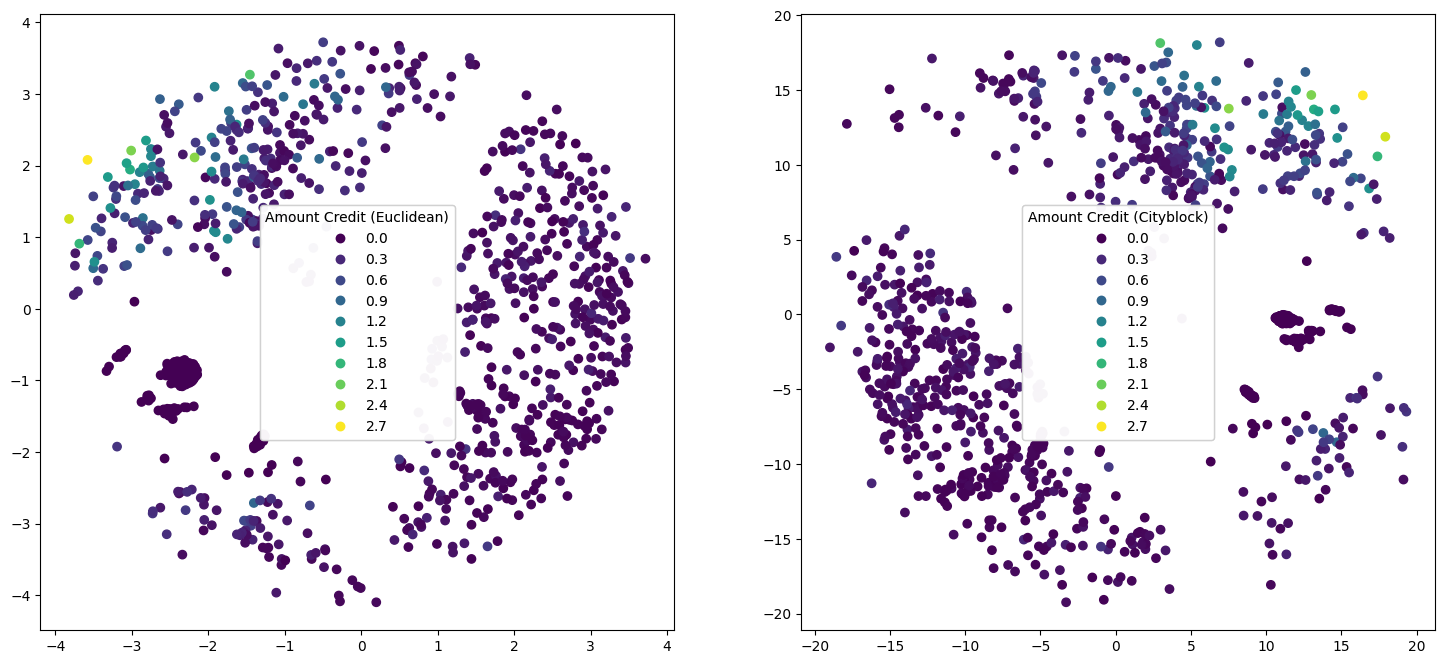

In [35]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

scatter1 = ax1.scatter(transformed[:,0], transformed[:,1], 
                       c=sample.AMT_CREDIT * max_amt_credit, cmap="viridis")
legend1 = ax1.legend(*scatter1.legend_elements(), title="Amount Credit (Euclidean)")
ax1.add_artist(legend1)

scatter2 = ax2.scatter(transformed_city[:,0], transformed_city[:,1], 
                       c=sample.AMT_CREDIT * max_amt_credit, cmap="viridis")
legend2 = ax2.legend(*scatter2.legend_elements(), title="Amount Credit (Cityblock)")
ax2.add_artist(legend2)

plt.show()


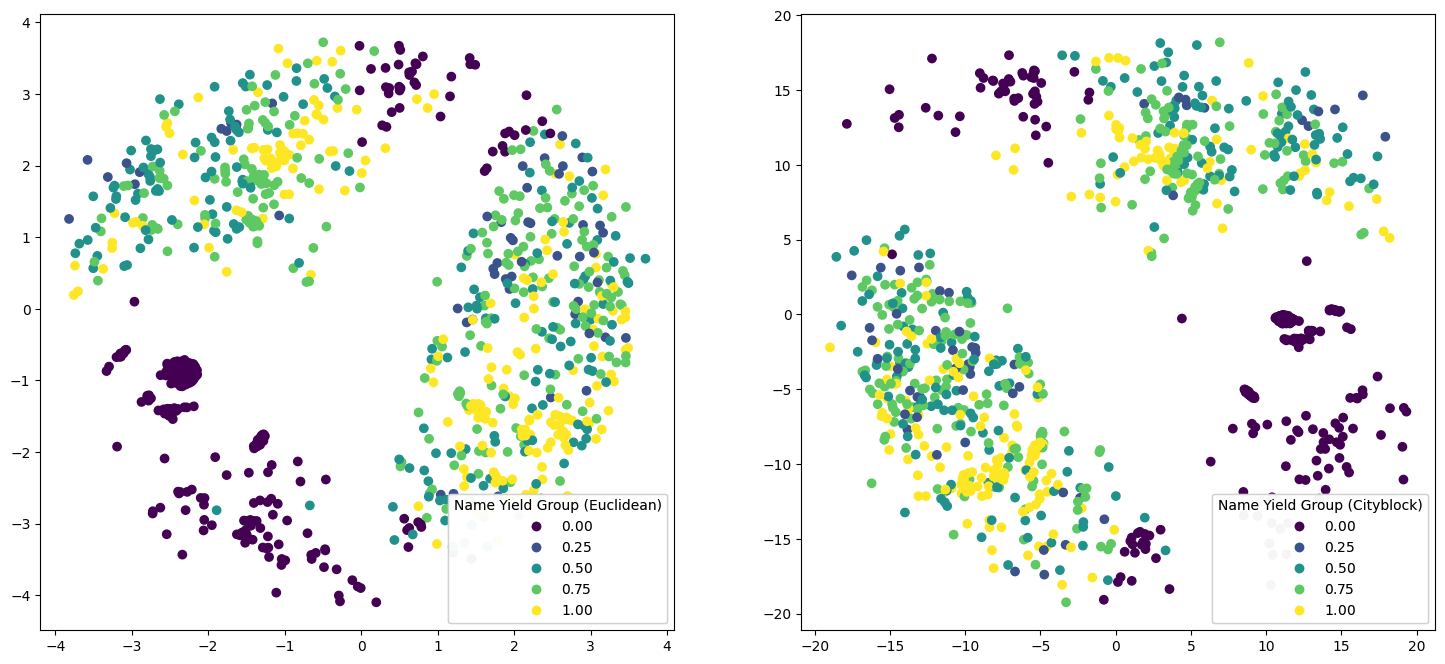

In [36]:

import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

scatter1 = ax1.scatter(transformed[:,0], transformed[:,1], 
                       c=sample.NAME_YIELD_GROUP , cmap="viridis")
legend1 = ax1.legend(*scatter1.legend_elements(), title="Name Yield Group (Euclidean)")
ax1.add_artist(legend1)

scatter2 = ax2.scatter(transformed_city[:,0], transformed_city[:,1], 
                       c=sample.NAME_YIELD_GROUP, cmap="viridis")
legend2 = ax2.legend(*scatter2.legend_elements(), title="Name Yield Group (Cityblock)")
ax2.add_artist(legend2)

plt.show()

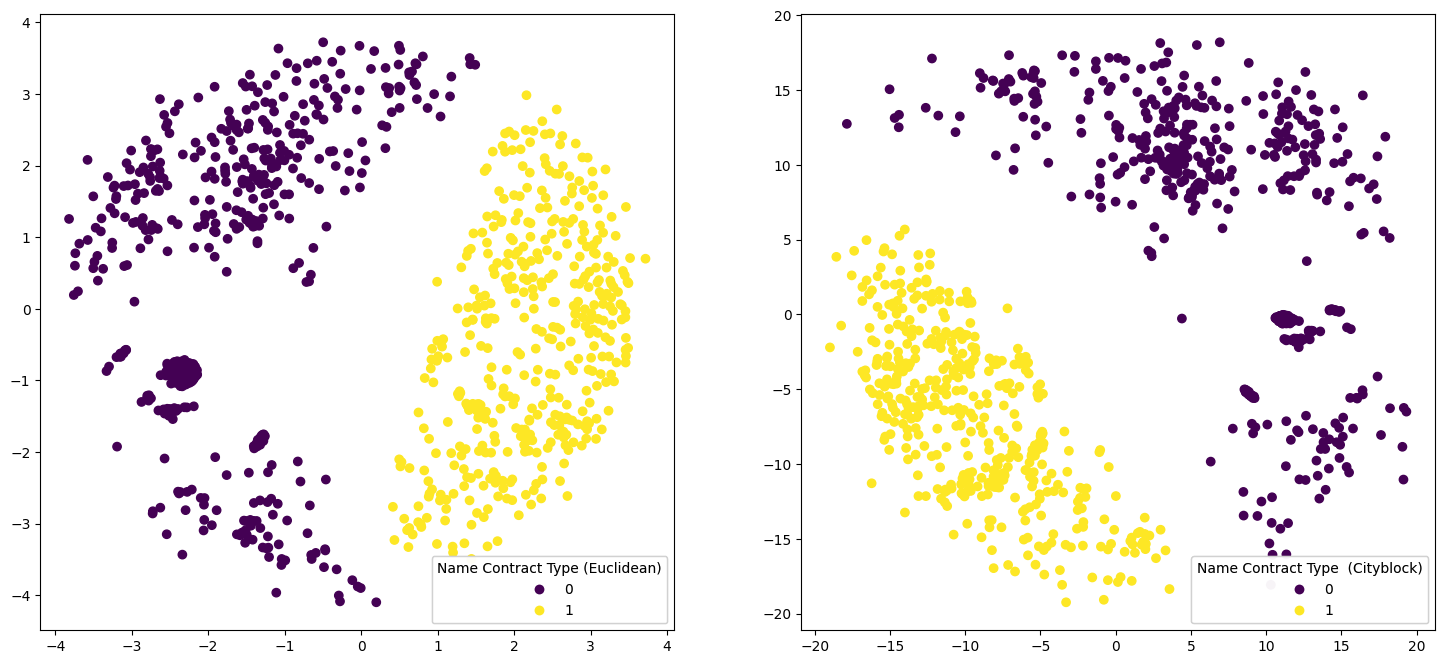

In [37]:

import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

scatter1 = ax1.scatter(transformed[:,0], transformed[:,1], 
                       c=sample.NAME_CONTRACT_TYPE_1 , cmap="viridis")
legend1 = ax1.legend(*scatter1.legend_elements(), title="Name Contract Type (Euclidean)")
ax1.add_artist(legend1)

scatter2 = ax2.scatter(transformed_city[:,0], transformed_city[:,1], 
                       c=sample.NAME_CONTRACT_TYPE_1, cmap="viridis")
legend2 = ax2.legend(*scatter2.legend_elements(), title="Name Contract Type  (Cityblock)")
ax2.add_artist(legend2)

plt.show()

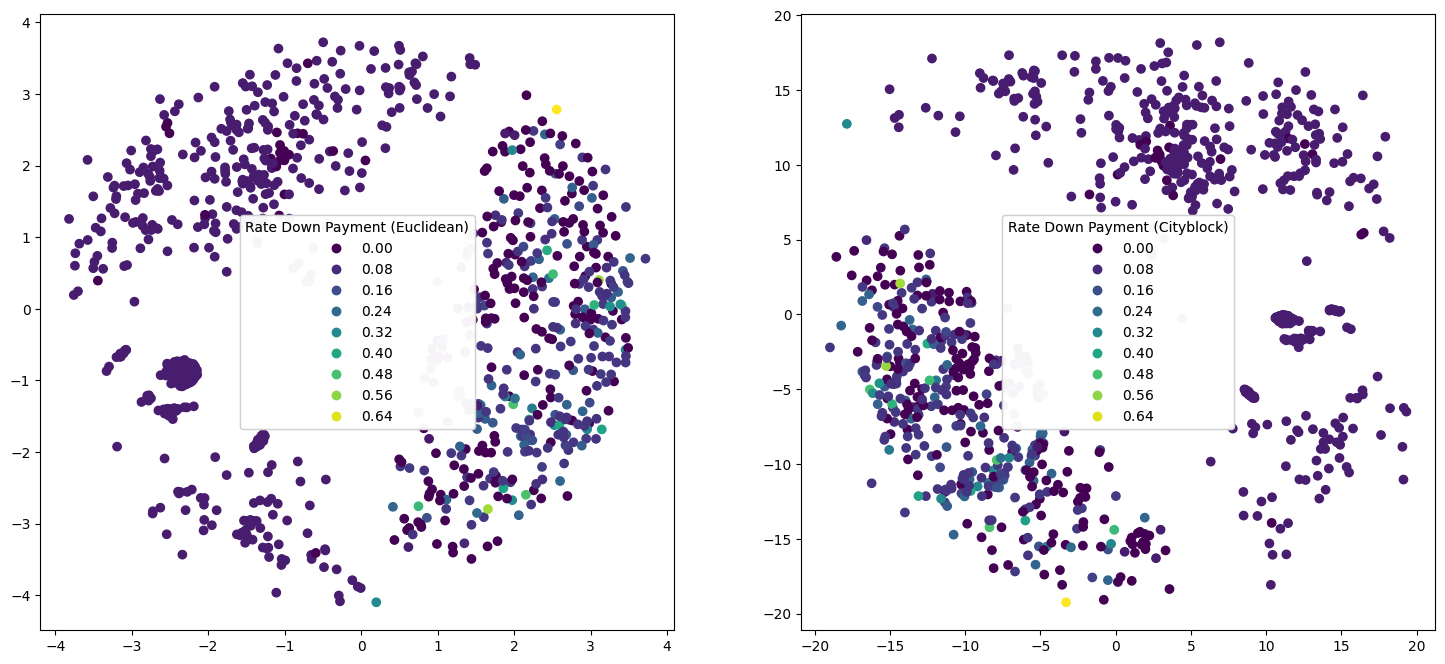

In [38]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

scatter1 = ax1.scatter(transformed[:,0], transformed[:,1], 
                       c=sample.RATE_DOWN_PAYMENT * max_rate_down_payment, cmap="viridis")
legend1 = ax1.legend(*scatter1.legend_elements(), title="Rate Down Payment (Euclidean)")
ax1.add_artist(legend1)

scatter2 = ax2.scatter(transformed_city[:,0], transformed_city[:,1], 
                       c=sample.RATE_DOWN_PAYMENT * max_rate_down_payment, cmap="viridis")
legend2 = ax2.legend(*scatter2.legend_elements(), title="Rate Down Payment (Cityblock)")
ax2.add_artist(legend2)

plt.show()


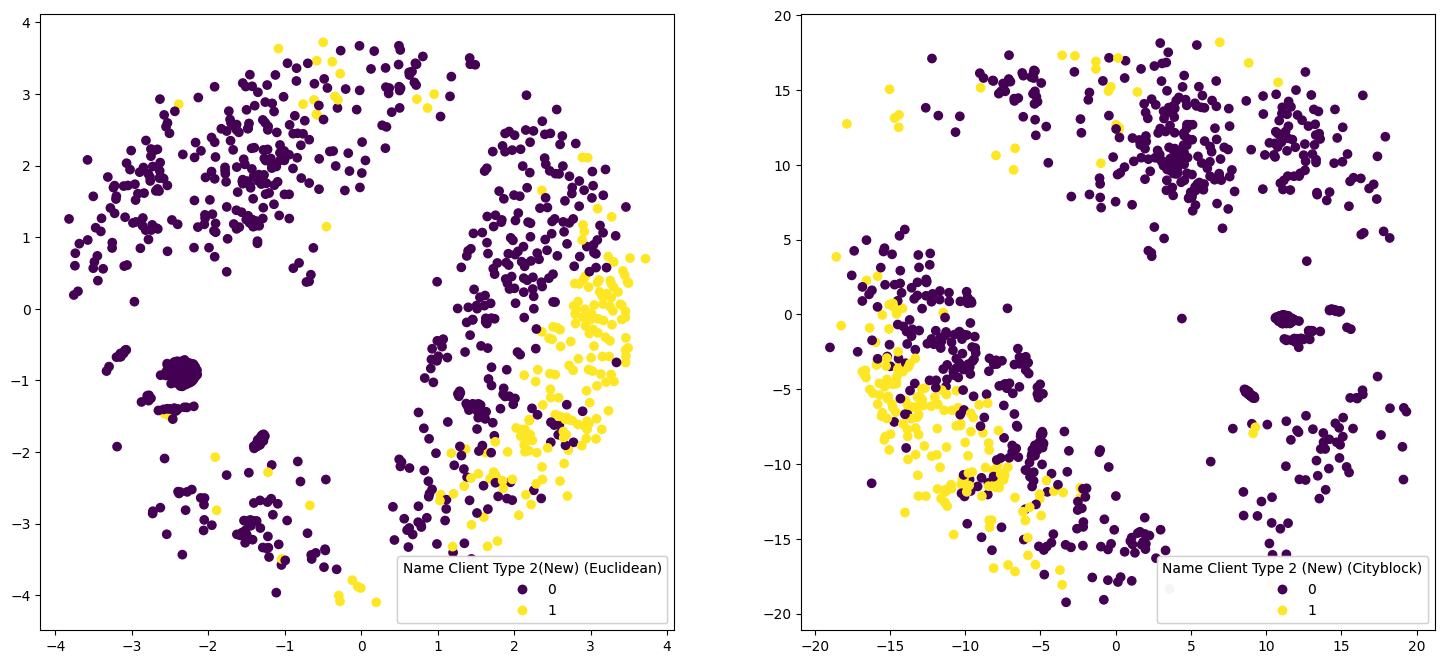

In [39]:

import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

scatter1 = ax1.scatter(transformed[:,0], transformed[:,1], 
                       c=sample.NAME_CLIENT_TYPE_2 , cmap="viridis")
legend1 = ax1.legend(*scatter1.legend_elements(), title="Name Client Type 2(New) (Euclidean)")
ax1.add_artist(legend1)

scatter2 = ax2.scatter(transformed_city[:,0], transformed_city[:,1], 
                       c=sample.NAME_CLIENT_TYPE_2, cmap="viridis")
legend2 = ax2.legend(*scatter2.legend_elements(), title="Name Client Type 2 (New) (Cityblock)")
ax2.add_artist(legend2)

plt.show()

## Asociaciones entre variables

Ahora investiguemos algunas asociaciones entre variables en esta base (usando la base original)

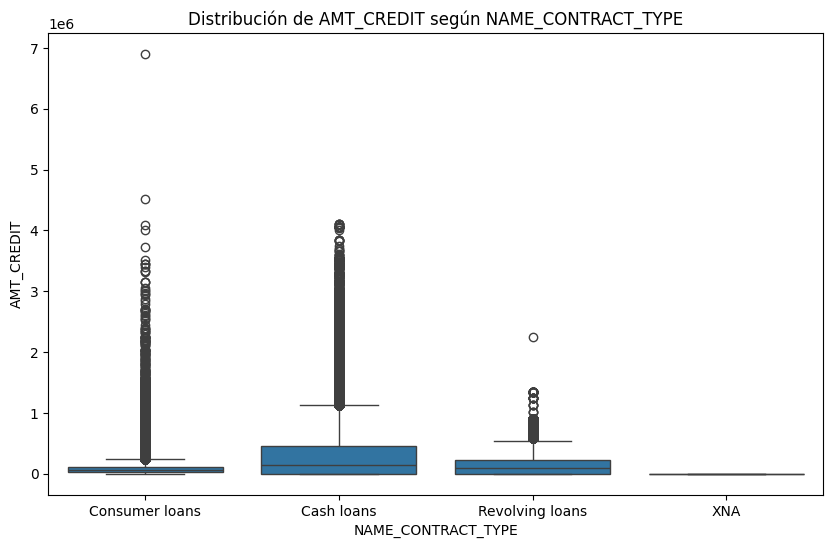

In [40]:

plt.figure(figsize=(10,6))
sns.boxplot(x=PREVIOUS['NAME_CONTRACT_TYPE'], y=PREVIOUS['AMT_CREDIT'])
plt.title('Distribución de AMT_CREDIT según NAME_CONTRACT_TYPE')
plt.show()
    


In [41]:

# Asociación entre dos variables categóricas
pd.crosstab(PREVIOUS['NAME_CONTRACT_TYPE'], PREVIOUS['NAME_CLIENT_TYPE'], margins=True, normalize='index').round(3)


NAME_CLIENT_TYPE,New,Refreshed,Repeater,XNA
NAME_CONTRACT_TYPE,,,,
Cash loans,0.029,0.072,0.897,0.002
Consumer loans,0.369,0.090,0.540,0.001
Revolving loans,0.055,0.082,0.861,0.001
XNA,0.061,0.069,0.870,0.000
All,0.180,0.081,0.737,0.001


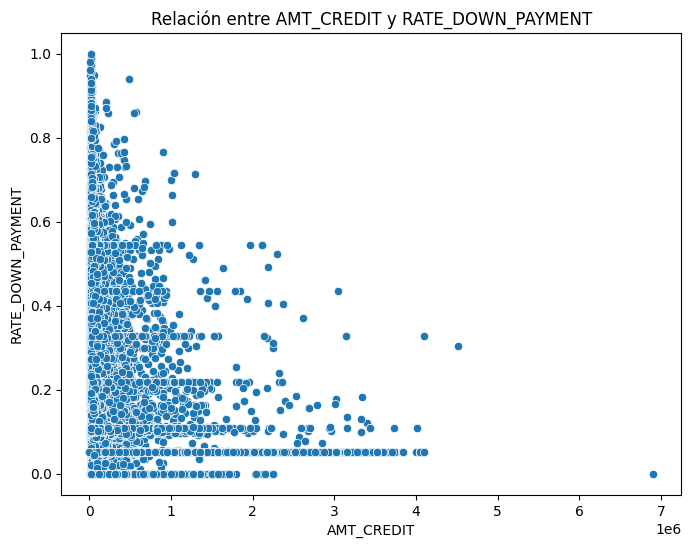

In [42]:

plt.figure(figsize=(8,6))
sns.scatterplot(x=PREVIOUS_3['AMT_CREDIT'], y=PREVIOUS_3['RATE_DOWN_PAYMENT'])
plt.title('Relación entre AMT_CREDIT y RATE_DOWN_PAYMENT')
plt.xlabel('AMT_CREDIT')
plt.ylabel('RATE_DOWN_PAYMENT')
plt.show()

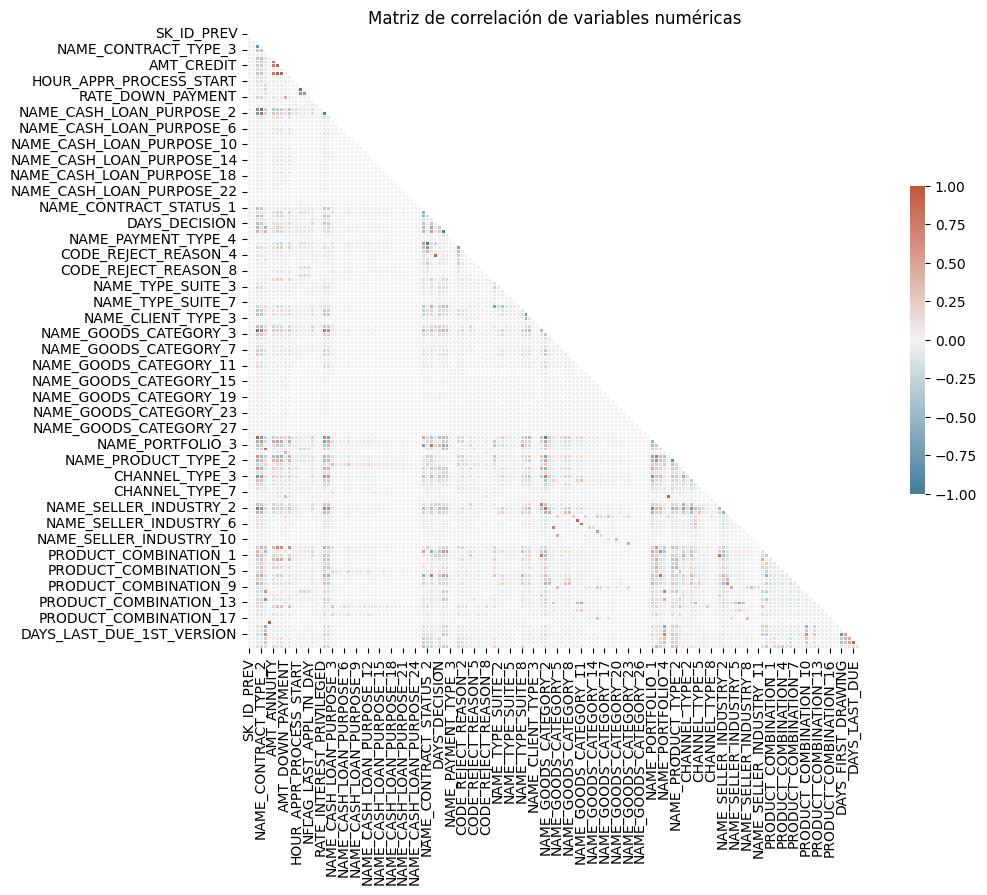

In [43]:
import numpy as np

cmap = sns.diverging_palette(230, 20, as_cmap=True)
corr = PREVIOUS_3.corr()


mask = np.triu(np.ones_like(corr, dtype=bool))  


plt.figure(figsize=(12, 8))
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=False)
plt.title('Matriz de correlación de variables numéricas')
plt.show()


In [44]:
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

class GeneralPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, mappings, num_fill='median', cat_fill='Desconocido', scaler=None):
        """
        mappings: List of dictionaries defining ordinal encodings.
          [{'col':'WEEKDAY_APPR_PROCESS_START','mapping':{'MONDAY':0,...}}, ...]
        """
        
        self.mappings = mappings
        self.num_fill = num_fill
        self.cat_fill = cat_fill
        self.scaler = scaler or StandardScaler()
        self.ct = None
        self.num_cols = self.cat_cols = self.ord_cols = self.ohe_cols = None
        self.feature_names_ = None

    def fit(self, X, y=None):
        X = X.copy()
        self.num_cols = X.select_dtypes(include='number').columns.tolist()
        self.cat_cols = X.select_dtypes(exclude='number').columns.tolist()

        # columnas con encoding ordinal (según mappings) y resto para one-hot
        map_by_col = {m['col']: list(m['mapping'].keys()) for m in self.mappings}
        self.ord_cols = [c for c in self.cat_cols if c in map_by_col]
        self.ohe_cols = [c for c in self.cat_cols if c not in self.ord_cols]

        ordinal_categories = [map_by_col[c] for c in self.ord_cols]

        self.ct = ColumnTransformer(
            transformers=[
                ('num', Pipeline([
                    ('imp', SimpleImputer(strategy=self.num_fill)),
                    ('sc', self.scaler),
                ]), self.num_cols),

                ('ord', Pipeline([
                    ('imp', SimpleImputer(strategy='constant', fill_value=self.cat_fill)),
                    ('enc', OrdinalEncoder(
                        categories=ordinal_categories,
                        handle_unknown='use_encoded_value',
                        unknown_value=-1
                    )),
                ]), self.ord_cols),

                ('ohe', Pipeline([
                    ('imp', SimpleImputer(strategy='constant', fill_value=self.cat_fill)),
                    ('enc', OneHotEncoder(handle_unknown='ignore', sparse_output=False)),
                ]), self.ohe_cols),
            ],
            remainder='drop'
        )

        self.ct.fit(X)
        try:
            self.feature_names_ = self.ct.get_feature_names_out()
        except Exception:
            self.feature_names_ = None
        return self

    def transform(self, X):
        return self.ct.transform(X)

    def save_transformed(self, X, filepath):
        arr = self.transform(X)
        if self.feature_names_ is not None:
            df = pd.DataFrame(arr, columns=self.feature_names_)
        else:
            df = pd.DataFrame(arr)
        df.to_csv(filepath, index=False)


In [45]:
df = PREVIOUS.copy()

mappings = [
    {'col': 'WEEKDAY_APPR_PROCESS_START',
     'mapping': {'MONDAY':0,'TUESDAY':1,'WEDNESDAY':2,'THURSDAY':3,'FRIDAY':4,'SATURDAY':5,'SUNDAY':6}},
    {'col': 'NAME_YIELD_GROUP',
     'mapping': {'low_action':0,'low_normal':1,'middle':2,'high':3,'XNA':-1}}
]

preproc = GeneralPreprocessor(mappings=mappings, scaler=StandardScaler())
preproc.fit(df)
datos_transformados = preproc.transform(df)   # numpy array
preproc.save_transformed(df, 'data/datos_transformados.csv')

Ejemplos de uso

In [46]:
datos_transformados = pd.read_csv('data/datos_transformados.csv')

In [47]:
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
pca_coords = pca.fit_transform(datos_transformados)
pca_df = pd.DataFrame(pca_coords, columns=['PC1', 'PC2'])


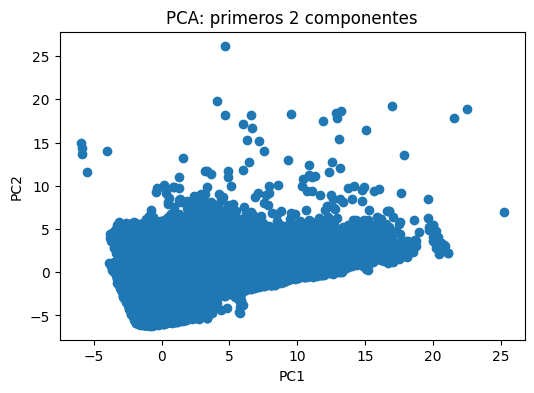

Varianza explicada: [0.15938041 0.11937497]


In [48]:

plt.figure(figsize=(6, 4))
plt.scatter(pca_df['PC1'], pca_df['PC2'])
plt.title('PCA: primeros 2 componentes')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

print('Varianza explicada:', pca.explained_variance_ratio_)


In [50]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(datos_transformados)
pca_df['cluster'] = labels


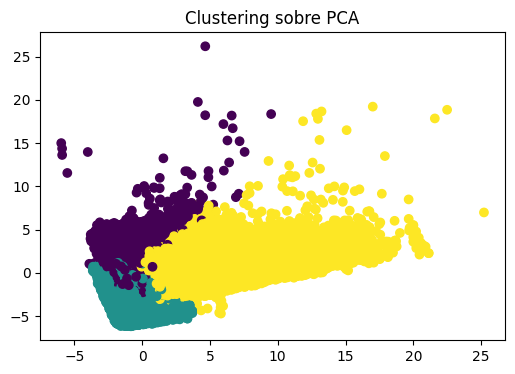

In [51]:

plt.figure(figsize=(6, 4))
plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['cluster'], cmap='viridis')
plt.title('Clustering sobre PCA')
plt.show()
